In [51]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime
from datetime import timedelta
from sklearn.grid_search import GridSearchCV

import sys
sys.path.append('/Users/drewrice/Desktop/Galvanize/Github/Galvanize-Final-Project/code')
from return_low_no_suit_score import return_low_no_suit_score

# Imports and feature selection

In [52]:
# using docs to model
# labels come from claims data 
claims = pd.read_csv('/Users/drewrice/Desktop/capson_csv/Claims.csv')
docs = pd.read_csv('/Users/drewrice/Desktop/capson_csv/ProviderInfo.csv')
prems = pd.read_csv('/Users/drewrice/Desktop/capson_csv/ScheduleOfWrittenPremium.csv')
debs_and_creds_full = pd.read_csv('/Users/drewrice/Desktop/capson_csv/ScheduleOfDebitsAndCredits.csv')
policy = pd.read_csv('/Users/drewrice/Desktop/capson_csv/PolicyInfo.csv')

In [53]:
# drop non-essential columns
# drop duplicates
docs.drop(['Middle Name','Address 1', 'Address 2', 'Zip','Address Type','Practice Start Date'],axis=1,inplace=True)
docs.drop_duplicates(inplace=True)

In [54]:
# grab essential columns for building classifier
indem = claims[['Indemnity_Paid','ProviderId']]

In [55]:
# docs DF, conversion to string
# lower ProviderId
docs[['ProviderId','Last Name','First Name','Gender','City','State','County']] = \
docs[['ProviderId','Last Name','First Name','Gender','City','State','County']].astype(str)
docs['ProviderId'] = docs['ProviderId'].map(lambda x: x if type(x)!=str else x.lower())

In [56]:
# indem DF, conversions to string and float
# lower ProviderId
indem['Indemnity_Paid'] = indem['Indemnity_Paid'].str.replace(r'[$,]', '').astype('float')
indem['ProviderId'] = indem['ProviderId'].astype(str)
indem['ProviderId'] = indem['ProviderId'].str.lower()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [57]:
# def build_classifier_label(item):
#     if item == 0:
#         return 'suit, no indem'
#     if item != 0:
#         return 'suit, indem'

def build_classifier_label(item):
    if item == 0:
        return 1
    if item != 0:
        return 2

In [58]:
indem['indem_label'] = indem['Indemnity_Paid'].apply(lambda item: build_classifier_label(item))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Join docs and indemnity tables, fill NaNs with 'no suit'

In [59]:
joined = pd.merge(docs, indem[['ProviderId', 'indem_label']], how='left', on='ProviderId')
joined.drop_duplicates(inplace=True)

In [60]:
# finish indemnity classifier
# find NaNs in indem_label column, replace with 'no suit'
def indem_label_no_suit(x):
    if type(x) == np.float_: 
        if np.isnan(x): 
#             return 'no suit'
            return 0
        else:
            return x

In [61]:
joined.indem_label = joined.indem_label.apply(lambda item: indem_label_no_suit(item))

# Claims data
#### building classifiers for BoardCredit and ClaimsBand, then merging with joined

In [62]:
def build_classifier(item):
    if item == 0:
        return 0
    if item != 0:
        return 1

In [63]:
# resave debs_and_creds with just the desired columns
# NOTE: typo 'RecordKepping'
debs_and_creds = debs_and_creds_full[['ProviderId','BoardCredit','ClaimsBand','Procedures','JCAHO','RecordKepping']]

# lower Provider Id
debs_and_creds['ProviderId'] = debs_and_creds['ProviderId'].map(lambda x: x if type(x)!=str else x.lower())
debs_and_creds.tail()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ProviderId,BoardCredit,ClaimsBand,Procedures,JCAHO,RecordKepping
8458,19d9c4e6-e820-41c4-b398-134e6c0ba410,-55,-220,0,0,0
8459,6398eeea-10af-448f-bd10-364be1d0c90c,0,-8951,0,-2984,0
8460,d54c0b59-08e5-4ed7-ba5a-413b2016b269,-1366,0,0,-1366,-2733
8461,3eacedf6-9173-4a64-89c7-ba8b6e150850,-88,0,0,0,0
8462,ea83f592-67dd-46d5-b15c-9d0738f81c93,0,-258,0,0,0


In [64]:
# group by Provider ID, resave debs_and_creds
debs_and_creds = debs_and_creds.groupby(debs_and_creds['ProviderId']).sum()
# reset index required
debs_and_creds.reset_index(inplace=True)

In [65]:
# use build_classifier to create binary column from BoardCredit & ClaimsBand
debs_and_creds['BoardCredit'] = debs_and_creds['BoardCredit'].apply(lambda item: build_classifier(item))
debs_and_creds['ClaimsBand'] = debs_and_creds['ClaimsBand'].apply(lambda item: build_classifier(item))
debs_and_creds['Procedures'] = debs_and_creds['Procedures'].apply(lambda item: build_classifier(item))
debs_and_creds['JCAHO'] = debs_and_creds['JCAHO'].apply(lambda item: build_classifier(item))
debs_and_creds['RecordKepping'] = debs_and_creds['RecordKepping'].apply(lambda item: build_classifier(item))

# Build 'joined'

In [66]:
joined = pd.merge(joined, debs_and_creds, how='left', on='ProviderId')

# EDA

In [67]:
# print num of doctors in each bucket, using the 
print 'Doctors wih no suits: ', joined[joined['indem_label'] == 0].sort(['Last Name']).shape[0]
print 'Doctors with suits, no indemnity paid: ', joined[joined['indem_label'] == 1].sort(['Last Name']).shape[0]
print 'Doctors with suits, indemnity paid: ', joined[joined['indem_label'] == 2].sort(['Last Name']).shape[0]

Doctors wih no suits:  6147
Doctors with suits, no indemnity paid:  281
Doctors with suits, indemnity paid:  41


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# Feature engineering

### ~ build age column ~

In [68]:
# convert DoB to datetime object
joined['Date of Birth'] = pd.to_datetime(joined['Date of Birth'])

In [69]:
# time_delta function
def time_delta(dt):
    if dt.year > 2000:
        dt = dt - timedelta(days=36525)
    return dt

In [70]:
# apply time_delta function to DoB column, deal with datetime rounding to the 2000s
joined['Date of Birth'] = joined['Date of Birth'].apply(lambda dt: time_delta(dt))

In [71]:
# fill missing values with 1/1/2060
joined['Date of Birth'].fillna(datetime(2060, 1, 1, 0, 0),inplace=True)

In [72]:
# build age column
now = datetime.now()
joined['age'] = now - joined['Date of Birth']

In [73]:
# function to convert years into days
def to_years(dt):
    if dt:
        dt = (dt.days) / 365.25
    return dt

In [74]:
# apply to_years function to age column
joined['age'] = (joined['age'].apply(lambda dt: to_years(dt))).round()

In [75]:
# refill Date of Birth with NaNs
joined['Date of Birth'].replace(datetime(2060, 1, 1, 0, 0), np.nan, inplace=True)

In [76]:
def refill_age(x):
    if x < 0:
        x = np.nan
    return x

In [77]:
# refill age with nan's for docs with missing birthdate
joined['age'] = (joined['age'].apply(lambda dt: refill_age(dt))).round()

In [78]:
joined.corr()

,indem_label,BoardCredit,ClaimsBand,Procedures,JCAHO,RecordKepping,age
indem_label,1.000000,0.131730,0.114054,0.157412,0.191448,0.048830,0.113572
BoardCredit,0.131730,1.000000,0.525431,0.034711,0.434245,0.171050,0.109570
ClaimsBand,0.114054,0.525431,1.000000,0.055314,0.445487,0.224323,0.350685
Procedures,0.157412,0.034711,0.055314,1.000000,-0.001525,-0.032338,0.048700
JCAHO,0.191448,0.434245,0.445487,-0.001525,1.000000,0.269885,0.062560
RecordKepping,0.048830,0.171050,0.224323,-0.032338,0.269885,1.000000,0.003344
age,0.113572,0.109570,0.350685,0.048700,0.062560,0.003344,1.000000


In [79]:
joined.dropna(how='any', inplace=True)
joined = joined.query('State != "nan"')
joined.shape

(2813, 15)

# Basic model

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

In [116]:
# drop rows with any NaN values
# not a long-term solution, but a quick and dirty model
no_suit = joined[joined.indem_label == 0]
suit_no_indem = joined[joined.indem_label == 1]
suit_indem = joined[joined.indem_label == 2]

no_suit.dropna(how='any', inplace=True)
suit_no_indem.dropna(how='any', inplace=True)
suit_indem.dropna(how='any', inplace=True)

# print totals after NaN drop
print no_suit.shape[0], suit_indem.shape[0], suit_no_indem.shape[0]

# !
# change values to 1 for binary classification
# suit_indem['indem_label'] = 1

# random sample from the three categories
no_suit = no_suit.sample(600)
suit_no_indem = suit_no_indem.sample(246)
suit_indem = suit_indem.sample(34)

2533 34 246


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [117]:
# combine random sample dataframes into concat_df
concat_df = pd.concat([no_suit, suit_indem, suit_no_indem], axis=0)

In [118]:
# build label and feature dataframes
y = concat_df.pop('indem_label')
to_model = concat_df[['BoardCredit','ClaimsBand','Procedures','JCAHO','age','RecordKepping']]
state = concat_df.pop('State')
dummies = pd.get_dummies(state)
to_model = pd.concat([to_model,dummies],axis=1)

In [119]:
# train / test split with random state
X_train, X_test, y_train, y_test = train_test_split(to_model, y, test_size=0.10)

In [120]:
model = RandomForestClassifier(n_estimators=64,oob_score=True)

In [121]:
# fit, validate with OOB score
model.fit(X_train,y_train)
model.oob_score_

0.65277777777777779

In [122]:
preds = model.predict(X_test)
model.score(X_test, y_test)

0.63636363636363635

In [123]:
confusion_matrix(y_test, preds)

array([[50, 10,  0],
       [18,  6,  3],
       [ 0,  1,  0]])

In [124]:
# grab indices from return_low_no_suit_score FUNC
low_no_suit_scores = return_low_no_suit_score(model,X_test)
indices = [x[0] for x in low_no_suit_scores]

# make y_test a list of values, from DataFrame
y_actual_list = y_test.values.tolist()
# take indices from return_low_no_suit_score FUNC
y_actual_list_appropriate_indices = [y_actual_list[x] for x in indices]

zip(low_no_suit_scores,y_actual_list_appropriate_indices)

[([0, 0.6536, 0.2839, 0.0625], 0.0),
 ([1, 0.3906, 0.6094, 0.0], 0.0),
 ([4, 0.6797, 0.1979, 0.1224], 1.0),
 ([5, 0.5313, 0.4219, 0.0469], 0.0),
 ([6, 0.5664, 0.3867, 0.0469], 0.0),
 ([10, 0.8073, 0.1771, 0.0156], 0.0),
 ([13, 0.4427, 0.5573, 0.0], 0.0),
 ([14, 0.5401, 0.4599, 0.0], 1.0),
 ([15, 0.6875, 0.2813, 0.0313], 0.0),
 ([19, 0.625, 0.3125, 0.0625], 1.0),
 ([21, 0.7721, 0.2279, 0.0], 1.0),
 ([22, 0.1042, 0.2083, 0.6875], 1.0),
 ([23, 0.7116, 0.2884, 0.0], 1.0),
 ([26, 0.5984, 0.0, 0.4016], 1.0),
 ([27, 0.2656, 0.7344, 0.0], 2.0),
 ([28, 0.4379, 0.5621, 0.0], 1.0),
 ([29, 0.3568, 0.487, 0.1563], 1.0),
 ([30, 0.4831, 0.5169, 0.0], 0.0),
 ([31, 0.0664, 0.9336, 0.0], 0.0),
 ([33, 0.0417, 0.9583, 0.0], 1.0),
 ([34, 0.2005, 0.7995, 0.0], 1.0),
 ([37, 0.4414, 0.5313, 0.0273], 0.0),
 ([39, 0.1094, 0.0938, 0.7969], 1.0),
 ([41, 0.4023, 0.5352, 0.0625], 0.0),
 ([42, 0.7188, 0.2344, 0.0469], 1.0),
 ([43, 0.3161, 0.6839, 0.0], 1.0),
 ([45, 0.4938, 0.4906, 0.0156], 1.0),
 ([46, 0.6969, 0.303

#### Gridsearching! Hooray for premature optimization

In [90]:
n_est_range = [32,64,80,85,90,95,100,120]
m_range = [2,3,4,5,6,8,16,32]
lrgs = GridSearchCV(estimator=model, param_grid=dict(n_estimators=n_est_range, max_depth=m_range), n_jobs=1)
lrgs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [32, 64, 80, 85, 90, 95, 100, 120], 'max_depth': [2, 3, 4, 5, 6, 8, 16, 32]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [91]:
print lrgs.best_score_
print lrgs.best_estimator_

0.698232323232
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

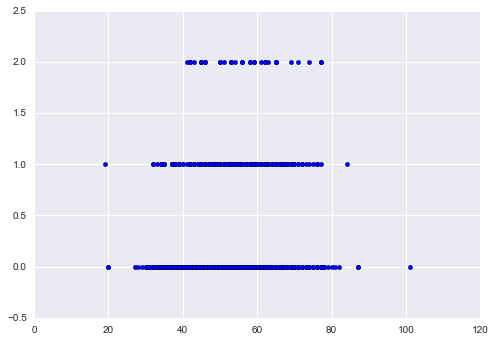

In [50]:
plt.scatter(to_model['age'], y)